In [46]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import networkx as nx

import dhg
from dhg import Graph
from dhg import Hypergraph
from dhg.data import Cora
from dhg.data import CoauthorshipCora
from dhg.data import YelpRestaurant
from dhg.data import Yelp3k
from dhg.data import IMDB4k
from dhg.models import GCN
from dhg.random import set_seed
from dhg.metrics import GraphVertexClassificationEvaluator as Evaluator

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Data

## Coauthorship Cora

In [3]:
dataset = CoauthorshipCora()
set_seed(42)
X = dataset['features'].to(device)
labels = dataset['labels'].to(device)
G = Hypergraph(dataset['num_vertices'], dataset['edge_list']).to(device)

In [4]:
# Print the data object
print("Data object:", dataset)

# Print the number of classes
num_classes = dataset['num_classes']
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['num_vertices']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset['dim_features']
print("Number of node features:", num_node_features)

# Print the edge index
print("Edge index:", dataset['edge_list'])

# Print the node features
print("Node features:", dataset['features'])

# Print the labels
print("Labels:", dataset['labels'])

# Print the train, validation, and test masks
train_mask = dataset['train_mask'].to(device)
val_mask = dataset['val_mask'].to(device)
test_mask = dataset['test_mask'].to(device)
print("Train mask:", train_mask)
print("Validation mask:", val_mask)
print("Test mask:", test_mask)

Data object: This is coauthorship_cora dataset:
  ->  num_classes
  ->  num_vertices
  ->  num_edges
  ->  dim_features
  ->  features
  ->  edge_list
  ->  labels
  ->  train_mask
  ->  val_mask
  ->  test_mask
Please try `data['name']` to get the specified data.
Number of classes: 7
Number of nodes: 2708
Number of node features: 1433
Edge index: [(235, 355), (1133, 1666, 1888), (783, 785), (570, 1058, 1211, 1246), (523, 717), (543, 603, 1163, 1355), (52, 140, 251, 323, 535, 865, 932, 1024, 1505, 1823, 2476, 2487, 2555, 2560, 2580), (1580, 2329), (701, 1019, 1659, 1869), (62, 270, 339, 495, 573, 723, 773, 1137, 1983, 2078, 2406, 2425, 2474, 2566), (269, 2415, 2438, 2530), (19, 424, 571, 1762, 2331, 2495, 2694), (487, 538, 1822, 2281), (877, 1010, 1578, 1651), (40, 114, 171, 488, 761, 798, 1124, 1390, 1566, 1567, 1661, 1888, 2053, 2054), (52, 701, 1019, 1539), (1538, 1724), (52, 2487, 2555), (141, 1184, 1959), (681, 1391, 2437), (1325, 2047), (476, 1787, 1871, 2385, 2676), (357, 803, 1

## Yelp Restaurant

In [39]:
dataset = YelpRestaurant()
set_seed(42)
X = dataset['features'].to(device)
labels = dataset['labels'].to(device)
G = Hypergraph(dataset['num_vertices'], dataset['edge_list']).to(device)

In [40]:
# Print the data object
#print("Data object:", dataset)

# Print the number of classes
num_classes = dataset['num_classes']
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['num_vertices']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset['dim_features']
print("Number of node features:", num_node_features)

# Print the edge index
#print("Edge index:", dataset['edge_list'])

# Print the node features
#print("Node features:", dataset['features'])

# Print the labels
#print("Labels:", dataset['labels'])

train_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
train_mask[:num_nodes // 2] = 1
val_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
val_mask[num_nodes // 2: 3 * num_nodes // 4] = 1
test_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
test_mask[3 * num_nodes // 4:] = 1


# Print the train, validation, and test masks
# train_mask = dataset['train_mask'].to(device)
# val_mask = dataset['val_mask'].to(device)
# test_mask = dataset['test_mask'].to(device)
print("Train mask:", train_mask)
print("Validation mask:", val_mask)
print("Test mask:", test_mask)

Number of classes: 6
Number of nodes: 3855
Number of node features: 1862
Train mask: tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')
Validation mask: tensor([False, False, False,  ..., False, False, False], device='cuda:0')
Test mask: tensor([False, False, False,  ...,  True,  True,  True], device='cuda:0')


## IMDB

In [49]:
dataset = IMDB4k()
set_seed(42)
X = dataset['features'].to(device)
labels = dataset['labels'].to(device)
G = Hypergraph(dataset['num_vertices'], dataset['edge_by_director']).to(device)

In [50]:
# Print the data object
#print("Data object:", dataset)

# Print the number of classes
num_classes = dataset['num_classes']
print("Number of classes:", num_classes)

# Print the number of nodes
num_nodes = dataset['num_vertices']
print("Number of nodes:", num_nodes)

# Print the number of node features
num_node_features = dataset['dim_features']
print("Number of node features:", num_node_features)

# Print the edge index
#print("Edge index:", dataset['edge_list'])

# Print the node features
#print("Node features:", dataset['features'])

# Print the labels
#print("Labels:", dataset['labels'])

train_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
train_mask[:num_nodes // 2] = 1
val_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
val_mask[num_nodes // 2: 3 * num_nodes // 4] = 1
test_mask = torch.zeros(num_nodes, dtype=torch.bool).to(device)
test_mask[3 * num_nodes // 4:] = 1


# Print the train, validation, and test masks
# train_mask = dataset['train_mask'].to(device)
# val_mask = dataset['val_mask'].to(device)
# test_mask = dataset['test_mask'].to(device)
print("Train mask:", train_mask)
print("Validation mask:", val_mask)
print("Test mask:", test_mask)

Number of classes: 3
Number of nodes: 4278
Number of node features: 3066
Train mask: tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')
Validation mask: tensor([False, False, False,  ..., False, False, False], device='cuda:0')
Test mask: tensor([False, False, False,  ...,  True,  True,  True], device='cuda:0')


# Models

## HCoGNN

In [51]:
from HCoGNN import HCoGNN_node_classifier

def random_walk_matrix(G):
    deg = G.deg_v
    v2e_weight = torch.ones_like(G.v2e_weight, dtype=torch.float32)
    e2v_weight = torch.ones_like(G.e2v_weight, dtype=torch.float32)
    for i, v in enumerate(G.v2e_src):
        v2e_weight[i] = 1.0 / deg[v]
    return v2e_weight, e2v_weight

model = HCoGNN_node_classifier(num_node_features, num_classes, G, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

edge_weight = random_walk_matrix(G)
model.to(device)

print("Model:", model)
print("Optimizer:", optimizer)
print("Model Device:", next(model.parameters()).device)
print("Data Device:", X.device)

Model: HCoGNN_node_classifier(
  (classifier): Linear(in_features=3066, out_features=3, bias=True)
  (action_net): action_network(
    (lin_message): Linear(in_features=3066, out_features=4, bias=False)
    (lin_update): Linear(in_features=3066, out_features=4, bias=True)
  )
  (environment_net): environment_network(
    (lin_message): Linear(in_features=3066, out_features=3066, bias=False)
    (lin_update): Linear(in_features=3066, out_features=3066, bias=True)
  )
)
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)
Model Device: cuda:0
Data Device: cuda:0


# Training

In [52]:
# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(X, edge_weight)
    loss = F.nll_loss(out[train_mask], labels[train_mask])
    #loss = F.cross_entropy(out[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def validate():
    model.eval()
    with torch.no_grad():
        logits = model(X) # Log probabilities

        # Train accuracy
        train_logits = logits[train_mask] # Log probabilities of train nodes
        train_labels = labels[train_mask] # True labels of train nodes
        train_pred = train_logits.max(1)[1] # Predicted labels
        train_correct = train_pred.eq(train_labels).sum().item() # Number of correctly classified nodes
        train_accuracy = train_correct / train_mask.sum().item() # Accuracy

        # Validation accuracy
        val_logits = logits[val_mask] # Log probabilities of validation nodes
        val_labels = labels[val_mask] # True labels of validation nodes
        val_pred = val_logits.max(1)[1] # Predicted labels
        val_correct = val_pred.eq(val_labels).sum().item() # Number of correctly classified nodes
        val_accuracy = val_correct / val_mask.sum().item() # Accuracy
            
    return train_accuracy, val_accuracy

# Testing function
def test():
    model.eval()
    with torch.no_grad():
        logits = model(X) # Log probabilities
        test_logits = logits[test_mask] # Log probabilities of test nodes
        test_labels = labels[test_mask] # True labels of test nodes
        pred = test_logits.max(1)[1] # Predicted labels
        correct = pred.eq(test_labels).sum().item() # Number of correctly classified nodes
        accuracy = correct / test_mask.sum().item() # Accuracy

        for layer in range(model.num_iterations):
            actions = model.action_history[layer].cpu()

            # Convert list to numpy array
            actions_array = np.array(actions)

            # Compute the ratio
            ratio = np.bincount(actions_array) / len(actions_array)

            print(f"Ratio of actions in layer {layer}: {ratio}")
                        
    return accuracy, pred

from sklearn.metrics import confusion_matrix

def visualize_results():
    model.eval()
    with torch.no_grad():
        logits = model(X) # Log probabilities
        test_logits = logits[test_mask] # Log probabilities of test nodes
        test_labels = labels[test_mask] # True labels of test nodes
        pred = test_logits.max(1)[1] # Predicted labels

        cm = confusion_matrix(test_labels.cpu(), pred.cpu())

        # Normalize confusion matrix
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        fig, ax = plt.subplots(1, 2, figsize=(20,10))

        # Plot confusion matrix
        im = ax[0].matshow(cm, cmap=plt.cm.Blues)
        plt.colorbar(im, ax=ax[0])
        ax[0].set_title('Confusion matrix')
        ax[0].set_ylabel('True label')
        ax[0].set_xlabel('Predicted label')

        plt.show()

In [53]:
# Run the training
for epoch in range(2000):
    loss = train()

    if epoch % 100 == 0:
        train_accuracy, val_accuracy = validate()
        print(f'Epoch {epoch+1}, Loss: {loss:.4f}')
        print(f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1, Loss: -0.3338
Training Accuracy: 0.4198, Validation Accuracy: 0.1833
Epoch 101, Loss: -0.7096
Training Accuracy: 0.7817, Validation Accuracy: 0.4752
Epoch 201, Loss: -0.8646
Training Accuracy: 0.8897, Validation Accuracy: 0.5472
Epoch 301, Loss: -0.9076
Training Accuracy: 0.9065, Validation Accuracy: 0.5454
Epoch 401, Loss: -0.9319
Training Accuracy: 0.9201, Validation Accuracy: 0.5529
Epoch 501, Loss: -0.9407
Training Accuracy: 0.9210, Validation Accuracy: 0.5500
Epoch 601, Loss: -0.9482
Training Accuracy: 0.9247, Validation Accuracy: 0.5491
Epoch 701, Loss: -0.9502
Training Accuracy: 0.9275, Validation Accuracy: 0.5444
Epoch 801, Loss: -0.9517
Training Accuracy: 0.9285, Validation Accuracy: 0.5444
Epoch 901, Loss: -0.9561
Training Accuracy: 0.9303, Validation Accuracy: 0.5463
Epoch 1001, Loss: -0.9549
Training Accuracy: 0.9313, Validation Accuracy: 0.5472
Epoch 1101, Loss: -0.9554
Training Accuracy: 0.9303, Validation Accuracy: 0.5529
Epoch 1201, Loss: -0.9583
Training Accur

Ratio of actions in layer 0: [0.25432445 0.24684432 0.25923329 0.23959794]
Test Accuracy: 0.5196, Training Accuracy: 0.9322, Validation Accuracy: 0.5379


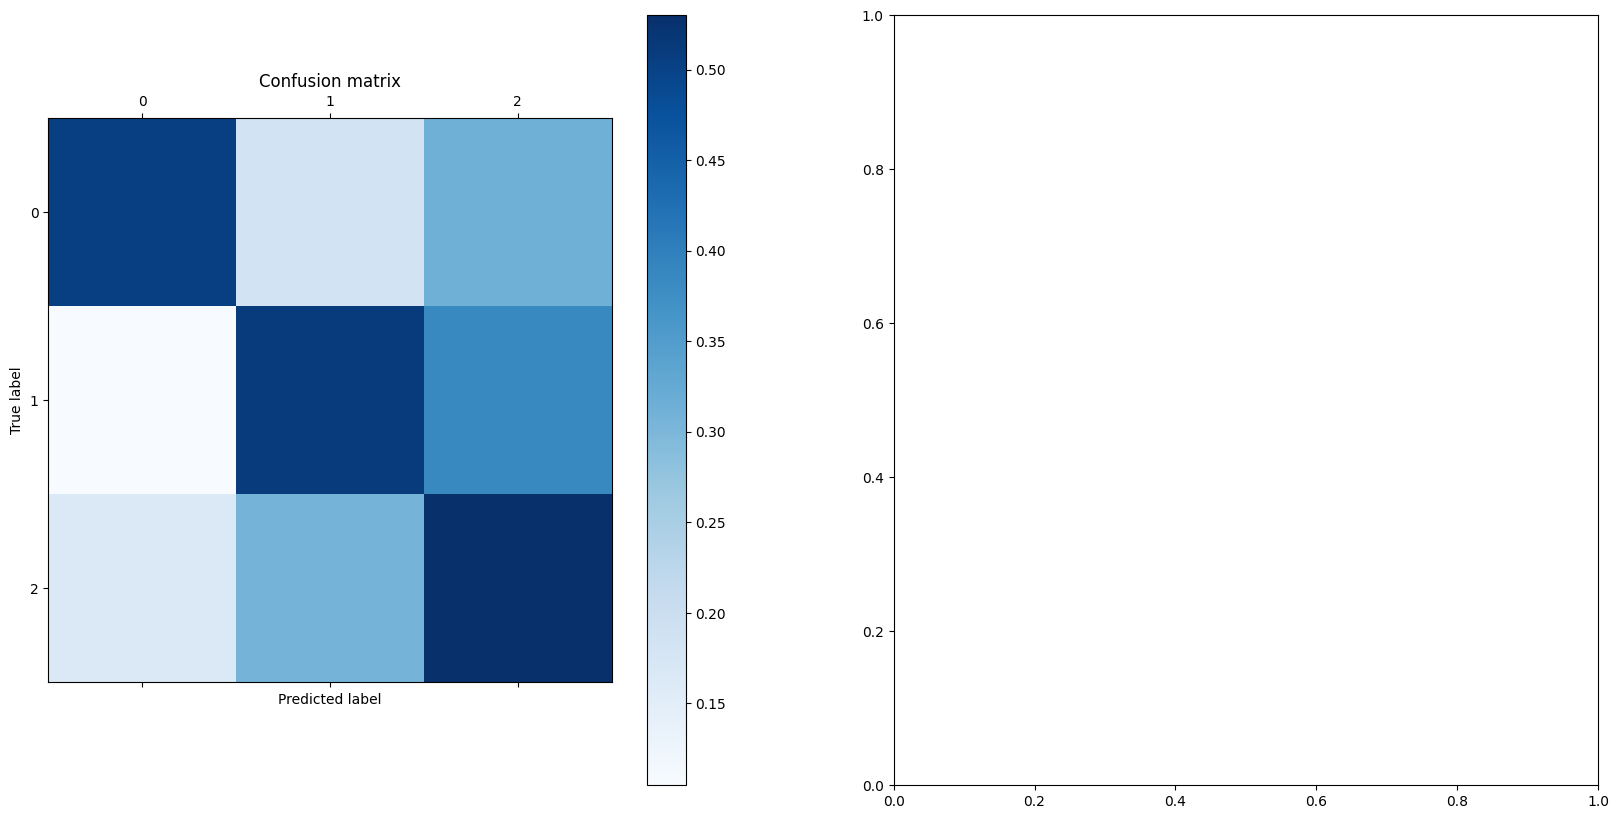

In [54]:
# Test the model
train_accuracy, val_accuracy = validate()
accuracy, predictions = test()
print(f'Test Accuracy: {accuracy:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

visualize_results()